<a href="https://colab.research.google.com/github/Preksha-4/Malaria-Predicton/blob/main/Copy_of_Malaria_Project_Branch_Pranav.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Malaria

*Abstract*: Causing over 600k deaths and 200 million cases, malaria is a major global health problem. Improving the identification of cases and efficiency of treatment is one way to help tackle this important issue. This dataset contains images of tissue samples labeled as positive or negative for malaria. Modelers will try to create an algorithm that can correctly identify cases of malaria in order to save the limited time of physicians and epidemiologists. Skills from this project will transfer to any image recognition or classification problem, but particularly those in the health care fields.

- Algorithms: Classification CNN

- Difficulty: Flexible! This dataset can utilize off-the-shelf algorithms from class, but has plenty of depth to warrant customization. The bar for accuracy is higher in health care because we are looking after people’s lives!

## Captone Project Link

Links to Capstone Project slides: [here](https://docs.google.com/presentation/d/1iEMLMUSAA-lEe4EzC0sCbiu405Bow7-4zGIj3SKN-1c/edit#slide=id.g107242abc6f_0_12)

## Motivation

Image classification using deep learning has become very popular, and seems to be one of the best methods. Images with more features (and higher resolution) require more sophisticated networks that are able to consider the translation invariance of features, and other important aspects of image classification. Image analysis is a promising application area for AI in medicine. This project will build skills to understand this application area and the challenges that it presents!


## Load Data

The following code use the *tfds* library to load in "malaria" data sets. This is a big image data set with over 27,000 images. The images are colored which means each image has RGB, i.e. 3 channels. Each image is sized 224 by 224.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report # for classifying as malaria or not
from skimage import color # for converting to greyscale
import random # for shuffling

In [ ]:
# this is how we load in the dataset!
# this is different from how previous code walk-throughs load in data
# this takes about 5 minutes to run, so start early!
ds_train, train_info = tfds.load('malaria', split='train', with_info=True, as_supervised=True)
# ds_train is the dataset, train_info is information about the dataset

# let's look at some information about the dataset
#train_info

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/incomplete.NED9JS_1.0.0/malaria-train.tfrecord*...:   0%|         …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [ ]:
# function to standardize the image size to what the model expects
def resize_image(image_tensor: tf.Tensor, label_tensor: tf.Tensor):
  im = image.array_to_img(image_tensor.numpy())
  im = im.resize((224, 224))
  im = image.img_to_array(im)
  image_tensor = tf.convert_to_tensor(im, dtype=tf.uint8)
  return image_tensor, label_tensor

# resize the image and shuffle the dataset
seed = 51
tf.random.set_seed(seed)
ds_train = ds_train.map(lambda x,y: tf.py_function(func=resize_image, inp=[x,y], Tout=(tf.uint8, tf.int64)))
ds_train.shuffle(buffer_size=1024, seed=seed)

<_ShuffleDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.uint8, name=None), TensorSpec(shape=<unknown>, dtype=tf.int64, name=None))>

In [ ]:
# this code runs for a while
# go get a cup of coffee!
# this formats our dataset into the appropriate images and labels (exploratory and target variables)
images = []
labels = []
N = 1000 # number of samples from each class
n_samps_0 = 0
n_samps_1 = 0
for image_0, label in ds_train:
  if (n_samps_0 == N) and (n_samps_1 == N):
    break
  if (label.numpy() == 0) and (n_samps_0 < N):
    images.append(color.rgb2gray(image_0.numpy()))
    labels.append(label.numpy())
    n_samps_0 += 1
  if (label.numpy() == 1) and (n_samps_1 < N):
    images.append(color.rgb2gray(image_0.numpy()))
    labels.append(label.numpy())
    n_samps_1 += 1
# now the data is ready for us to use!
# everything up until this point should take about 7 minutes to run

In [ ]:
# check number of samples
print("We have " + str(len(images)) + " image samples and " + str(len(labels)) + " label samples")

# convert to numpy arrays
images = np.array(images)
labels = np.array(labels)

# check sizes
print(images.shape)
print(labels.shape)

We have 2000 image samples and 2000 label samples
(2000, 224, 224)
(2000,)


## Define Research Question

## EDA

Examples:

- You can count the number of classes in this data.
- You examine the images according to class labels.
- You can plot the averages of pixel-level values across all images in a particular class. In addition, you can also span the visualization for all classes.

You can refer to more resources here in this [code](https://colab.research.google.com/drive/1KkG1V7RsnKjCRd0zx0h434nqiXwOf-fG?authuser=1).

In [ ]:
# now that our data is ready to use, let's split it into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=0)

# check the shape
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1400, 224, 224)
(1400,)
(600, 224, 224)
(600,)


In [ ]:
# print original training and testing image shapes
print(X_train.shape)
print(X_test.shape)

# add empty color dimension since CNN is expecting this
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

# check new training and testing image shapes
print(X_train.shape)
print(X_test.shape)
# this should match the expected input dimensions of the CNN

(1400, 224, 224)
(600, 224, 224)
(1400, 224, 224, 1)
(600, 224, 224, 1)


## Baseline Model

Fundamentally, a baseline is a model that is both simple to set up and has a reasonable chance of providing decent results.

# To do:

1) Separate training and testing sets

2) Create a traditional neural network model for classification. Code examples are [here](https://colab.research.google.com/drive/1OGxD35fQxXdWNDwYGYpZcES5zgo6UvdO?authuser=1) for reference.

3) Plot your training and testing accuracy across epochs


## Challenge:

- Create another neural net with a different layer configuration. Does it improve performance?


In [ ]:
# we will start by replicating the CNN used in the Week 7 code walk-through

model = tf.keras.models.Sequential()

model.add(
    tf.keras.layers.Conv2D(
        filters=32, # How many filters we will learn
        kernel_size=(3, 3), # Size of feature map that will slide over image
        strides=(1, 1), # How the feature map "steps" across the image
        padding='valid', # We are not using padding
        activation='relu', # Rectified Linear Unit Activation Function
        input_shape=(224, 224, 1) # The expected input shape for this layer
    )
)


model.add(
    tf.keras.layers.MaxPooling2D(
        pool_size=(2, 2), # Size feature will be mapped to
        strides=(4, 4) # How the pool "steps" across the feature
    )
)

# We'll now add a dropout layer. This fights overfitting and forces the model to
# learn multiple representations of the same data by randomly disabling neurons
# in the learning phase.
model.add(
     tf.keras.layers.Dropout(
         rate=0.25 # Randomly disable 25% of neurons
     )
 )

model.add(
    tf.keras.layers.Flatten()
)

model.add(
    tf.keras.layers.Dense(
        units=128, # Output shape
        activation='relu' # Rectified Linear Unit Activation Function
    )
)

model.add(
    tf.keras.layers.Dense(
        units=2, # Output shape
        activation='softmax' # Softmax Activation Function
    )
)

# Build the model
model.compile(
    loss=tf.keras.losses.sparse_categorical_crossentropy, # loss function
    optimizer=tf.keras.optimizers.Adam(), # optimizer function
    metrics=['accuracy'] # reporting metric
)

# Display a summary of the models structure
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      12,845,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,845,762 (49.00 MB)

 Trainable params: 12,845,762 (49.00 MB)

 Non-trainable params: 0 (0.00 B)

Visualize the model.  We can also use this [site](http://alexlenail.me/NN-SVG/LeNet.html) to draw graphical representation of neural network architectures.

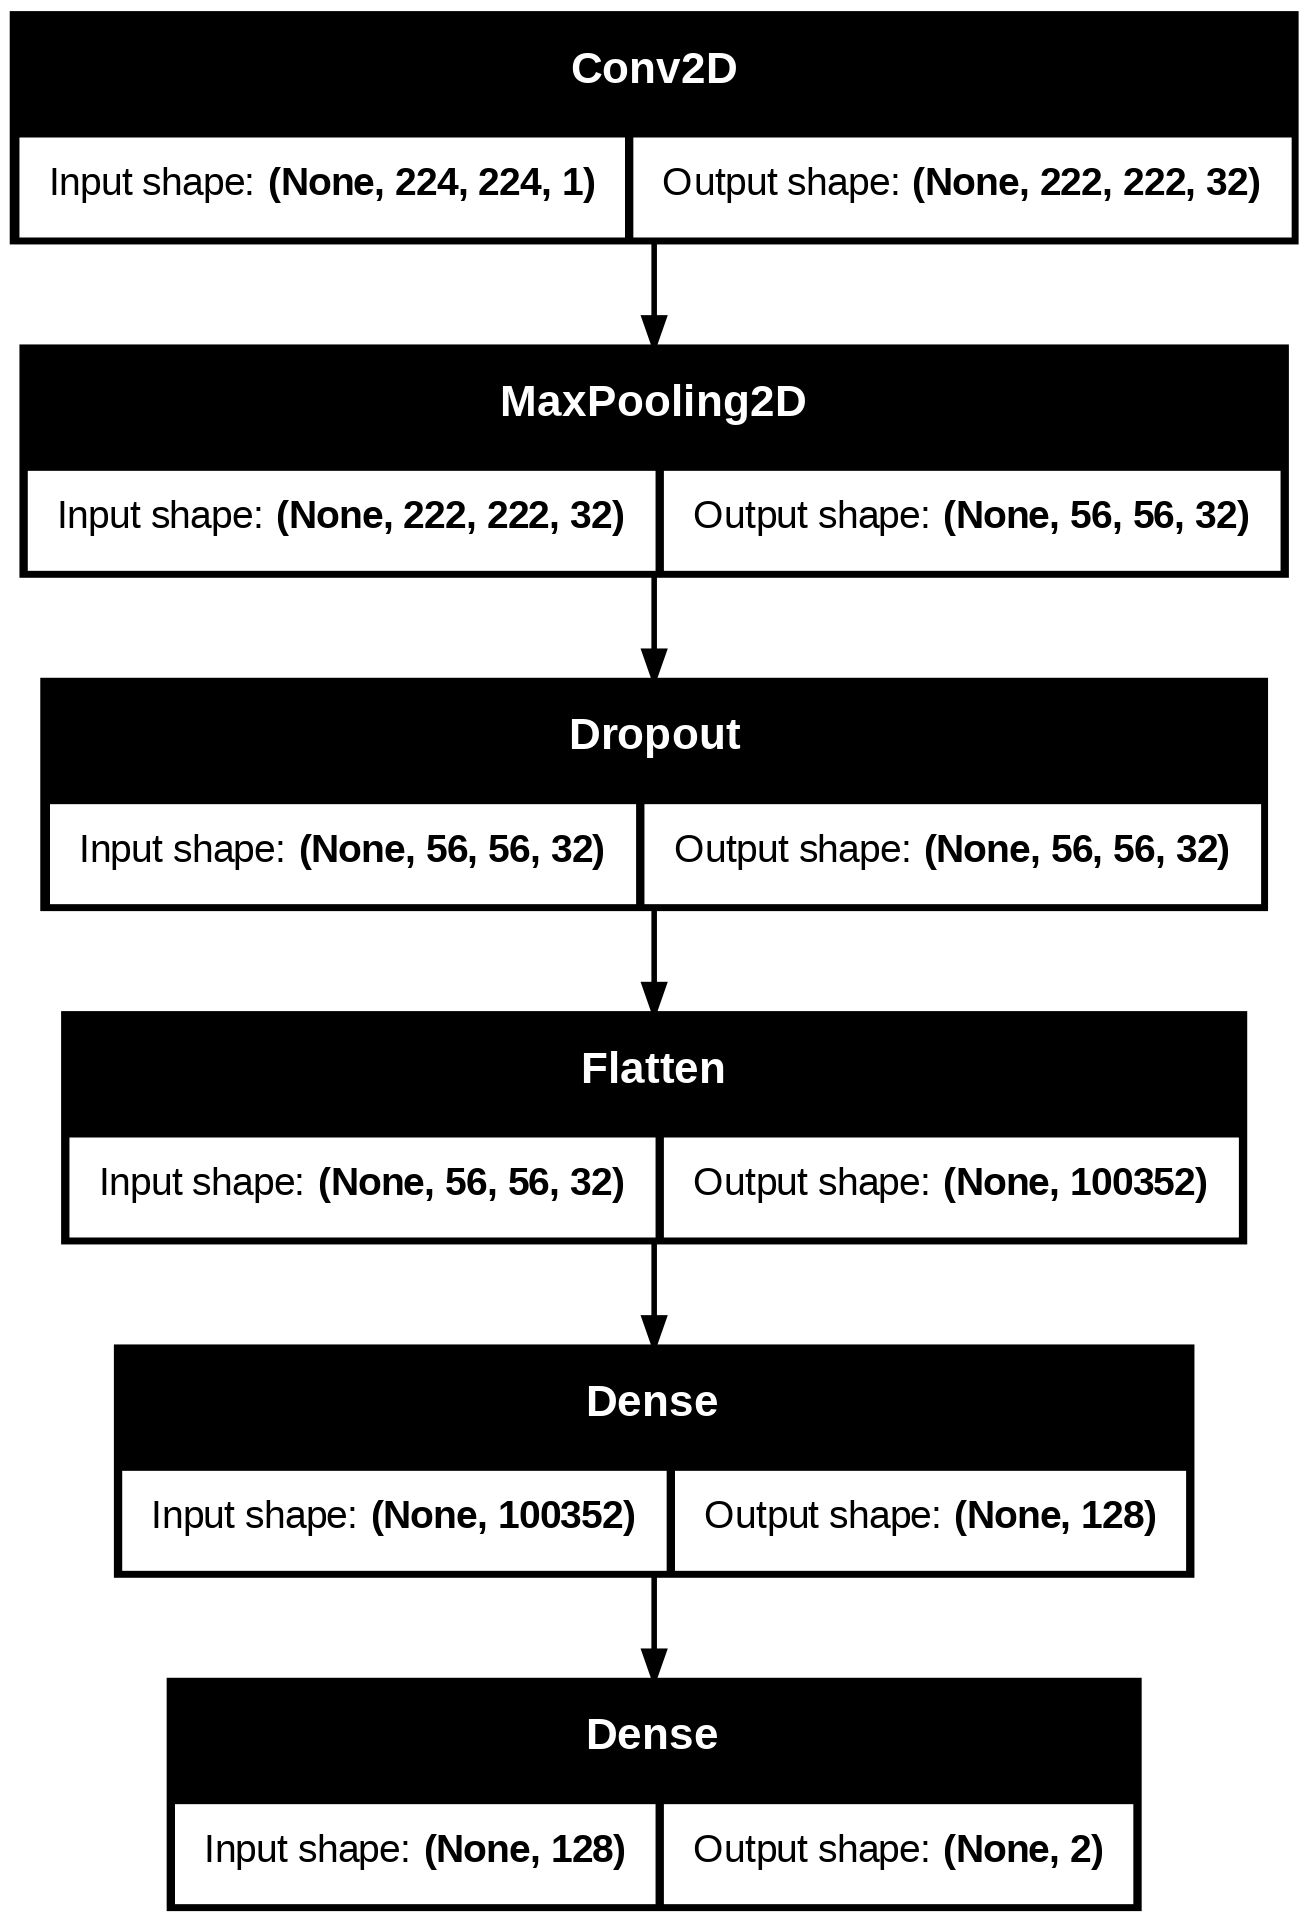

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)

In [ ]:
# Train the CNN on the training data
history = model.fit(

      # Training data : features (images) and classes.
      X_train, y_train,

      # number of samples to work through before updating the
      # internal model parameters via back propagation.
      batch_size=100,

      # An epoch is an iteration over the entire training data.
      epochs=10,

      # The model will set apart his fraction of the training
      # data, will not train on it, and will evaluate the loss
      # and any model metrics on this data at the end of
      # each epoch.
      validation_split=0.2,

      verbose=1)

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.5605 - loss: 4.0118 - val_accuracy: 0.5143 - val_loss: 1.4258
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.5000 - loss: 1.1547 - val_accuracy: 0.4893 - val_loss: 0.8475
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.5564 - loss: 0.7072 - val_accuracy: 0.5464 - val_loss: 0.7650
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.6351 - loss: 0.6286 - val_accuracy: 0.5071 - val_loss: 0.7223
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.6761 - loss: 0.5939 - val_accuracy: 0.5214 - val_loss: 0.7114
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.7118 - loss: 0.5575 - val_accuracy: 0.5179 - val_loss: 0.7054
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.7681 - loss: 0.5059 - val_accuracy: 0.5464 - val_loss: 0.7070
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8208 - loss: 0.4533 - val_accuracy: 0.6214 - val_loss:

19/19 - 5s - 244ms/step - accuracy: 0.5967 - loss: 0.6915


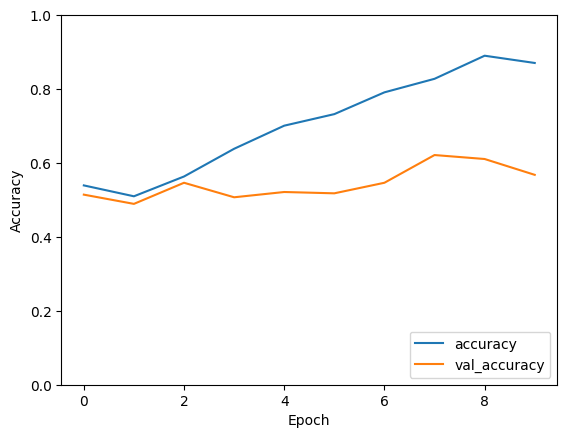

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1]) # recall accuracy is between 0 to 1
plt.legend(loc='lower right') # specify location of the legend

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

Evaluate the model with testing data

In [ ]:
# Get Model Predictions for test data
predicted_classes = model.predict(X_test)
predicted_classes = np.argmax(predicted_classes, axis=1)

# TODO check class names
print(classification_report(y_test, predicted_classes, target_names=['malaria', 'no malaria']))

19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 308ms/step
              precision    recall  f1-score   support

     malaria       0.64      0.38      0.47       290
  no malaria       0.58      0.80      0.67       310

    accuracy                           0.60       600
   macro avg       0.61      0.59      0.57       600
weighted avg       0.61      0.60      0.58       600



## Advanced Model

Examples:
- Build a model that is more complex or can improve upon your predictions for classification.

## Model Tuning

Recall in Week 5, we discussed hyperparameters tuning. You can refer to this code [here](https://colab.research.google.com/drive/1BdW6zSQ2XAUcLI83CANcFBQaBw5WgepK).

## Performance Summary

Make a presentation of your result. You can refer to the syntax below.

Markdown | Preview
--- | ---
`**Model 1**` | **Model 2**
`*70%*` or `_italicized text_` | *90%*
`` `Monospace` `` | `Monospace`
`~~strikethrough~~` | ~~strikethrough~~
`[A link](https://www.google.com)` | [A link](https://www.google.com)
`![An image](https://www.google.com/images/rss.png)` | ![An image](https://www.google.com/images/rss.png)

More resources about creating tables in markdown of colab can be found [here](https://colab.research.google.com/notebooks/markdown_guide.ipynb#scrollTo=Lhfnlq1Surtk).

## Interpretation and Future Work

Present and also interpret your experimental performance. Comment on potential future work or research questions that your project leads to.

# MESSING AROUND, IGNORE FROM HERE ON

## Selecting Images from Full Dataset

In [ ]:
# check original size of dataset
print("Starting with " + str(len(images)) + " image samples and " + str(len(labels)) + " label samples")

# get indices of labels for class 0 and 1 separately
labels_0 = [i for i in range(len(labels)) if labels[i] == 0]
labels_1 = [i for i in range(len(labels)) if labels[i] == 1]

# select first N samples for each class (2*N total samples)
sample_indices = labels_0[:N]
sample_indices.extend(labels_1[:N])

# shuffle indices to ensure random order
random.shuffle(sample_indices)

# only select the appropriate 2*N sample images and labels
images_subset = []
labels_subset = []
for i in sample_indices:
  images_subset.append(images[i])
  labels_subset.append(labels[i])

# now we have a much smaller subset of images and labels to work with
print("Now consider " + str(len(images_subset)) + " image samples and " + str(len(labels_subset)) + " label samples")

Starting with 2000 image samples and 2000 label samples
Now consider 2000 image samples and 2000 label samples


## Modifying Images

In [ ]:
# look at the shape of our data
# note that above, images and labels were defined to be lists
# this means we need to use len as opposed to shape or size
# print(len(X_train))
# print(len(y_train))
# print(len(X_test))
# print(len(y_test))

In [ ]:
# look at the shape of one image
print("size of first image: ", X_train[0].shape)
# look at the corresponding label
print("image label: ", y_train[0])

size of first image:  (224, 224, 1)
image label:  1


How would you explain the image size?  What does each dimension represent?

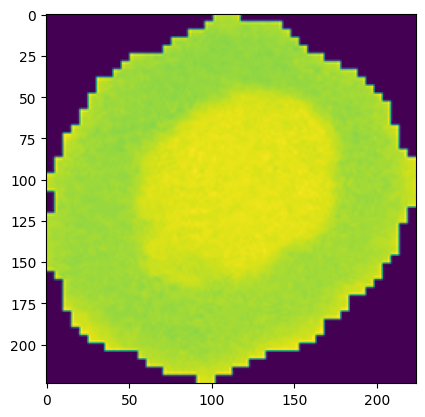

In [ ]:
# look at one RGB image
plt.imshow(X_train[0])
plt.show()

In [ ]:
# rather than dealing with the three R, G, B channels separately, we might want to consider the greyscale image

# convert all training and testing images to greyscale (causes crash and uses too much RAM)
# X_train_greyscale = []
# for i in range(len(X_train)):
#   img_grey = color.rgb2gray(X_train[i])
#   X_train_greyscale.append(img_grey)
# X_test_greyscale = []
# for i in range(len(X_test)):
#   img_grey = color.rgb2gray(X_test[i])
#   X_test_greyscale.append(img_grey)

In [ ]:
# look at one greyscale image
plt.imshow(color.rgb2gray(X_train[0])) #X_train_greyscale[0]
plt.show()
# image may not look greyscale, depending on matplotlib's color scale; might see white to black, green to purpose, white to red, etc.

ValueError: the input array must have size 3 along `channel_axis`, got (224, 224, 1)